In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
# PathSavedImages = '/content/drive/MyDrive/Semester 6/Course Resources/ANN/Theory/Project/Denoising/Saved Images/'
# PathModel = '/content/drive/MyDrive/Semester 6/Course Resources/ANN/Theory/Project/Denoising/Model/'
# PathTrainImages = '/content/drive/MyDrive/Semester 6/Course Resources/ANN/Theory/Project/Denoising/Images npy train/'
# PathTestImages = '/content/drive/MyDrive/Semester 6/Course Resources/ANN/Theory/Project/Denoising/Images npy test/'
# PathValImages = '/content/drive/MyDrive/Semester 6/Course Resources/ANN/Theory/Project/Denoising/Images npy val/'

PathSavedImages = '../Saved Images/'
PathModel = '../Model/'
PathTrainImages = '../Images npy train/'
PathTestImages = '..//Images npy test/'
PathValImages = '../Images npy val/'

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imshow,imsave,imread
from skimage import exposure,filters
from skimage.transform import resize
from skimage.filters import unsharp_mask
import warnings
warnings.filterwarnings('ignore')
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [23]:
#empty the generated images folder
if os.path.exists(PathSavedImages):
    shutil.rmtree(PathSavedImages)
    print('Generated Images Folder Emptied')
    os.mkdir(PathSavedImages)

Generated Images Folder Emptied


In [24]:
Train_Data_Dir = PathTrainImages
Test_Data_Dir = PathTestImages
Val_Data_Dir = PathValImages

In [25]:
ImageSize = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('The device is: ', device)

The device is:  cpu


# Original Samples

Displaying some random original samples


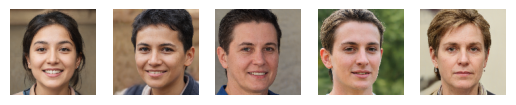

In [26]:
RandomSamples = [os.listdir(Train_Data_Dir)[x] for x in np.random.randint(0, len(os.listdir(Train_Data_Dir)), 5)]
print('Displaying some random original samples')
for i in range(len(RandomSamples)):
    RandomSamples[i] = Train_Data_Dir + RandomSamples[i]
    img = np.load(RandomSamples[i])
    img = exposure.rescale_intensity(img, in_range=(-1, 1), out_range=(0, 1))
    img = img.transpose(1, 2, 0)
    img = np.array(img).astype(dtype=np.float32)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [27]:
noise = 0.25

In [28]:
#create class for dataset
class FaceDataset(Dataset):
    def __init__(self, Data_Dir):
        self.Data_Dir = Data_Dir
        self.Images = os.listdir(self.Data_Dir)
        self.Images = [self.Data_Dir + i for i in self.Images]
        
    def __len__(self):
        return len(self.Images)
    
    def __getitem__(self, index):
        image = np.load(self.Images[index]) #load image
        image = exposure.rescale_intensity(image, in_range=(-1, 1), out_range=(0, 1)) #Normalize image
        image = torch.tensor(image).float() #convert to tensor
        image = image.to(device)  #send to device
        return image

In [29]:
TrainDataset = FaceDataset(Train_Data_Dir)
TrainDataLoader = DataLoader(TrainDataset, batch_size=1)

ValDataset = FaceDataset(Val_Data_Dir)
ValDataLoader = DataLoader(ValDataset, batch_size=1)

TestDataset = FaceDataset(Test_Data_Dir)
TestDataLoader = DataLoader(TestDataset, batch_size=1)

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, stride=1, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, stride=1, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, stride=1, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=40, stride=1, kernel_size=5),
            nn.BatchNorm2d(40),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=40, out_channels=32, stride=1, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, stride=1, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, stride=1, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=3, stride=1, kernel_size=5),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )
        
    def forward(self, data):
        encodedData = self.encoder(data)
        decodedData = self.decoder(encodedData)
        resized_tensor = torch.nn.functional.interpolate(decodedData.unsqueeze(0), size=(3,128,128), mode='nearest').squeeze(0).to(device)
        return resized_tensor

In [31]:
model = AutoEncoder().to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 124, 124]             608
       BatchNorm2d-2          [-1, 8, 124, 124]              16
              ReLU-3          [-1, 8, 124, 124]               0
            Conv2d-4         [-1, 16, 120, 120]           3,216
       BatchNorm2d-5         [-1, 16, 120, 120]              32
              ReLU-6         [-1, 16, 120, 120]               0
            Conv2d-7         [-1, 32, 116, 116]          12,832
       BatchNorm2d-8         [-1, 32, 116, 116]              64
              ReLU-9         [-1, 32, 116, 116]               0
           Conv2d-10         [-1, 40, 112, 112]          32,040
      BatchNorm2d-11         [-1, 40, 112, 112]              80
             ReLU-12         [-1, 40, 112, 112]               0
  ConvTranspose2d-13         [-1, 32, 116, 116]          32,032
      BatchNorm2d-14         [-1, 32, 1

In [32]:
n_epochs = 2
lr = 0.001

In [33]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = lr) #,weight_decay=0.05

# Training

In [34]:
def UnSharp_Masking(img):
    img = unsharp_mask(img, radius=15, amount=1.25)
    return img

def Contrast_Streching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img        

def DeNormalize(img):
    return exposure.rescale_intensity(img, in_range=(0,1), out_range=(-1,1))
                               
def DisplayImage(noisy_actual, actual, generated, save=True, filename='test.jpg'):
    actual = actual[0].transpose(1,2,0)
    noisy_actual = noisy_actual[0].detach().cpu().numpy().transpose(1,2,0)
    generated = generated[0].detach().cpu().numpy().transpose(1,2,0)
    
    plt.subplot(1,3,1)
    plt.imshow(actual)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(noisy_actual)
    plt.title('Noisy')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(generated)
    plt.title('Generated')
    plt.axis('off')    
    if save:
        plt.savefig(PathSavedImages + filename)
    plt.show()
    
    
def Save_Model(filename, model):
    torch.save(model.state_dict(), filename)

  0%|          | 0/2 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  1 Batch:  387


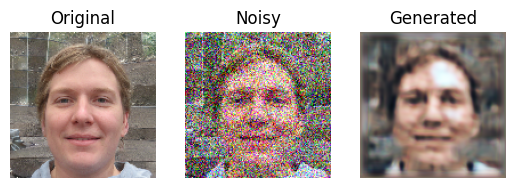

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  1 Batch:  566


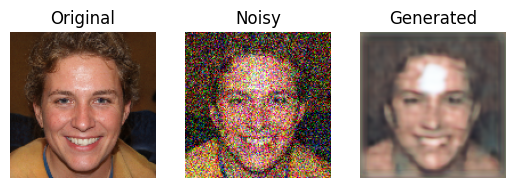

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  1 Batch:  603


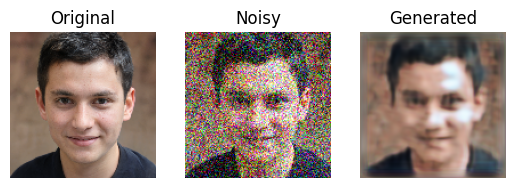

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  1 Batch:  1478


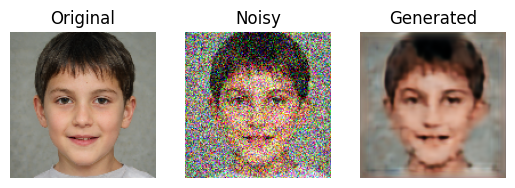

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  1 Batch:  1723


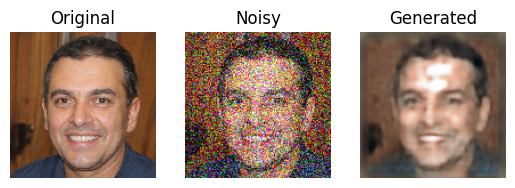

epoch [1/2], loss:0.0174


 50%|█████     | 1/2 [03:41<03:41, 221.54s/it]

***************


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  2 Batch:  258


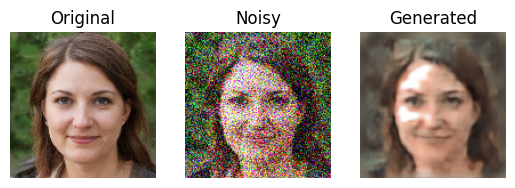

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  2 Batch:  574


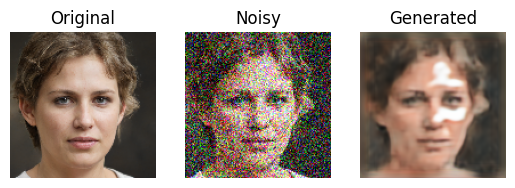

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  2 Batch:  759


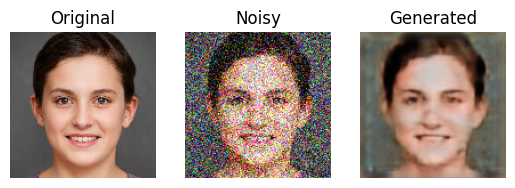

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  2 Batch:  1298


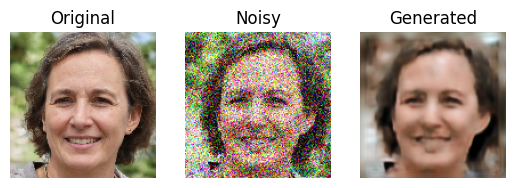

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  2 Batch:  1779


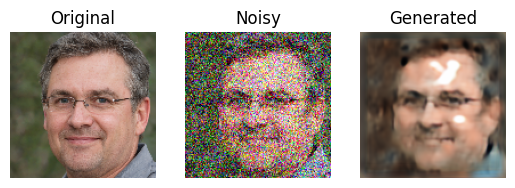

epoch [2/2], loss:0.0147


100%|██████████| 2/2 [07:35<00:00, 227.61s/it]

***************


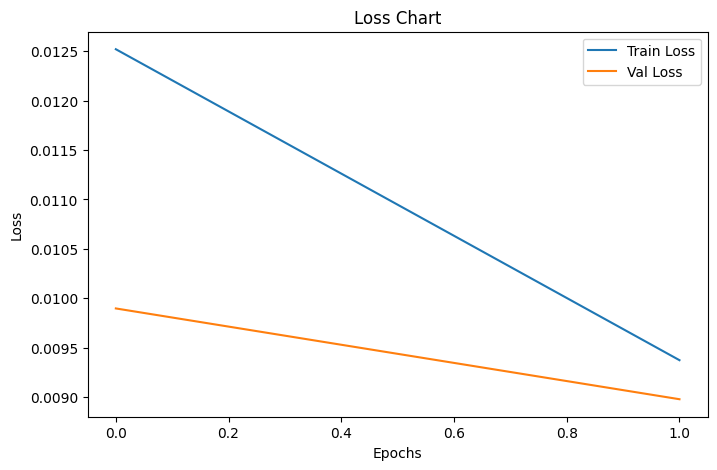

In [35]:
TrainLoss = []
ValLoss = []
for epoch in tqdm(range(n_epochs)):
    IndicesToDisplayImageAt = np.random.randint(0, len(TrainDataLoader), 5)
    Temp_Loss = []
    noise += 0.0015
    
    for idx,data in enumerate(TrainDataLoader):
        optimizer.zero_grad()
        
        data = data.detach().cpu().numpy()
        noisy_data = torch.tensor(data + np.random.normal(0, noise, data.shape).astype(dtype=np.float32)).to(device)
        output = model(noisy_data)
        
        if idx in IndicesToDisplayImageAt:
            print('Epoch: ', epoch+1, 'Batch: ', idx+1)
            DisplayImage(noisy_data, data, output, save=True, filename='Train_'+str(epoch+1)+'_'+str(idx+1)+'.jpg')
        
        data = torch.tensor(data).to(device)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        Temp_Loss.append(loss.item())
        
    TrainLoss.append(np.mean(Temp_Loss))
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, n_epochs, loss.item()))
    Save_Model(PathModel+'Epoch_'+str(epoch)+'_autoencoder_denoiser.pth', model)

    TempValLoss = []
    for idx,data in enumerate(ValDataLoader):
        data = data.detach().cpu().numpy()
        noisy_data = torch.tensor(data + np.random.normal(0, noise, data.shape).astype(dtype=np.float32)).to(device)
        output = model(noisy_data)
        
        # print('Validation Example: ', idx+1)
        # DisplayImage(noisy_data, data, output, save=True, filename='Val_'+str(epoch+1)+'_'+str(idx+1)+'.jpg')

        data = torch.tensor(data).to(device)
        loss = criterion(output, data)

        TempValLoss.append(loss.item())
    print('*'*15)
    
    ValLoss.append(np.mean(TempValLoss))
    
plt.figure(figsize=(8,5))
plt.plot(TrainLoss, label='Train Loss')
plt.plot(ValLoss, label='Val Loss')
plt.legend(loc=1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Chart')
plt.savefig('../Metrics/Train Loss_Chart.jpg')
plt.show()

# Testing

Test on some random test samples


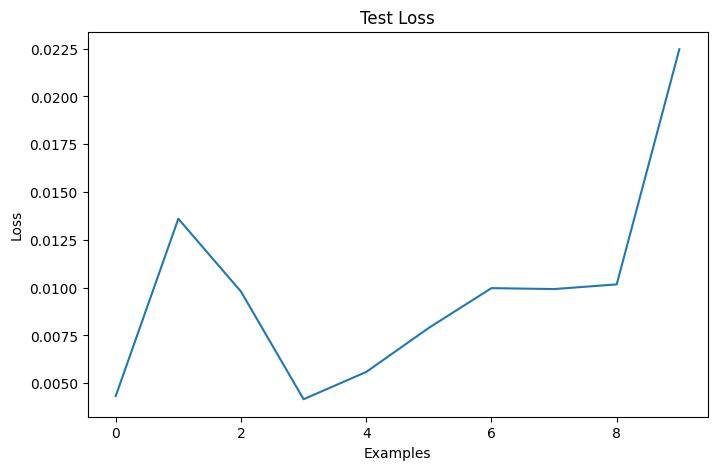

In [37]:
print('Test on some random test samples')

TestLoss = []
IndicesToRecordLossAt= np.random.randint(0, len(TestDataLoader), 10)
for idx,data in enumerate(TestDataLoader):
    data = data.detach().cpu().numpy()
    noisy_data = torch.tensor(data + np.random.normal(0, noise, data.shape).astype(dtype=np.float32)).to(device)
    output = model(noisy_data)
        
    # print('Test Example: ', idx+1)
    # DisplayImage(noisy_data, data, output, save=True, filename='Test_'+str(idx+1)+'.jpg')

    data = torch.tensor(data).to(device)
    loss = criterion(output, data)

    if idx in IndicesToRecordLossAt:
        TestLoss.append(loss.item())

plt.figure(figsize=(8,5))
plt.plot(TestLoss)
plt.xlabel('Examples')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.savefig('../Metrics/Test Loss_Chart.jpg')
plt.show()